In [1]:
from firedrake import *
import matplotlib.pyplot as plt
import numpy as np
from icepack import compute_surface
from icepack.constants import ice_density as rho_I, water_density as rho_W
from glac_adapt.adapt import mismip_bed_topography


firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


In [21]:
path = '/data/glac_adapt/test_cases/mismip/ref_soln/output'

def get_haf(h, s, Q):
    return interpolate(s - (1 - rho_I / rho_W) * h, Q)

def get_volumes(name, idx, input_mesh):
    fpath = f"{path}/{name}.h5"

    with CheckpointFile(fpath, 'r') as afile:
        # mesh = afile.load_mesh("firedrake_default")
        volumes = []
        for i in range(idx+1):
            h = afile.load_function(input_mesh, "thickness", idx=i)
            volumes.append(assemble(h*dx) / (1e9 * 917))
    
    return volumes

def load_fields(name, idx, volume=True):
    fpath = f"{path}/{name}.h5"

    with CheckpointFile(fpath, 'r') as afile:
        mesh = afile.load_mesh("firedrake_default")
        if volume:
            volumes = []
            for i in range(idx+1):
                h = afile.load_function(mesh, "thickness", idx=i)
                volumes.append(assemble(h*dx))
                u = afile.load_function(mesh, "velocity", idx=i)
        else:
            h = afile.load_function(mesh, "thickness", idx=idx)
            u = afile.load_function(mesh, "velocity", idx=idx)

    z_b = mismip_bed_topography(mesh, 80e3)
    s = compute_surface(thickness=h, bed=z_b)

    Q = FunctionSpace(mesh, "CG", 1)
    haf = get_haf(h, s, Q)

    if volume:
        volumes = np.array(volumes) / (1e9 * 917)
        return u, h, haf, volumes
    
    return u, h, haf

def plot_grounding_line(*hafs, colors=None, labels=None):
    n_hafs = len(hafs)
    
    levels = [-0.1, 0.01]
    fig, axes = plt.subplots(figsize=(13, 4))
    axes.set_xlim([440e3, 530e3])

    for i in range(n_hafs):
        im = tricontour(hafs[i], levels=levels, axes=axes, colors=colors[i], label="a")#labels[i])

    axes.legend(loc="best")

    return fig, axes

In [42]:
coarse_mesh = RectangleMesh(320, 40, 640e3, 80e3)
fpath = f"{path}/steady-state-0.h5"
# with CheckpointFile(fpath, 'r') as afile:
#     test_mesh = afile.load_mesh("firedrake_default")

with CheckpointFile('test.h5', 'w') as afile:
    afile.save_mesh(coarse_mesh)

with CheckpointFile('test.h5', 'r') as afile:
    test_mesh = afile.load_mesh("firedrake_default")

test_mesh.sfXC

In [45]:
# coarse_mesh = RectangleMesh(320, 40, 640e3, 80e3)
mesh_hierarchy = MeshHierarchy(coarse_mesh, 1)

volumes = get_volumes('steady-state-0', 12, mesh_hierarchy[0])

AttributeError: 'MeshTopology' object has no attribute 'sfXC'

In [33]:
Q_in = FunctionSpace(coarse_mesh, family='CG', degree=1)
V_in = VectorFunctionSpace(coarse_mesh, family='CG', degree=1)
    

with DumbCheckpoint(fpath, mode=firedrake.FILE_READ) as chk:
    timesteps, indices = chk.get_timesteps()
    chk.set_timestep(timesteps[-1], idx=indices[-1])

    chk.load(h_in, name='h')
    chk.load(u_in, name='u')

Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 203)

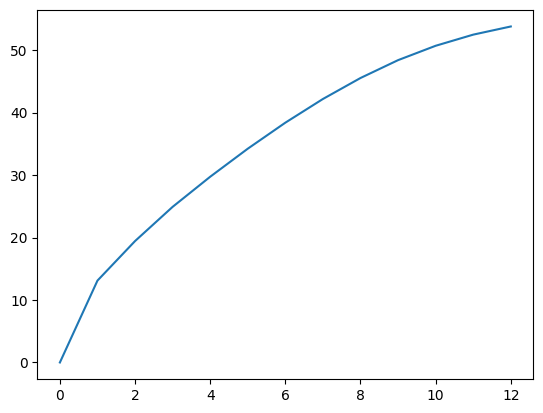

In [35]:
plt.plot(np.arange(len(volumes)), volumes)